# Setup - remote processing
Run this section if using remote processing (provided by Google) 

In [ ]:

# MOUNT GOOGLE DRIVE 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
%matplotlib inline

# IMPORT LIBRARIES
import sys
import os
import numpy as np
import csv
import pandas as pd
import math
from scipy.optimize import curve_fit
import random
import glob
import subprocess
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.stats import norm


In [ ]:

PARENT_DIR = '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/'

# Ensure that Python looks in correct place for local modules 
DIR = PARENT_DIR

DIR_runs = PARENT_DIR+ 'RunMultipleRankings/' 

sys.path.append(DIR)

# IMPORT OWN FUNCTIONS
from utils.read_data_fns import *
from utils.target_method_fns import *  
from utils.knee_method_fns import *  
from utils.eval_fns import *
from utils.inhomogeneous_pp_fns import *  


# Setup - local processing 


**Execute using local compute** 
(See https://research.google.com/colaboratory/local-runtimes.html)

Start notebook: 

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [ ]:
PARENT_DIR = 'C:/Users/reemb/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/'

# Ensure that Python looks in correct place for local modules 
DIR = PARENT_DIR

DIR_runs = PARENT_DIR+ 'RunMultipleRankings/' 

sys.path.append(DIR)

# IMPORT OWN FUNCTIONS
from utils.read_data_fns import *
from utils.eval_fns import *
from utils.inhomogeneous_pp_fns import *   # updated version moved

# Setup - shared

In [ ]:
# Setup evaluation directory
EVALDIR = os.path.join(DIR, 'RunMultipleRankings', 'tar_eval_out')    # Directory for evaluation output files

# Check whether dircetory exists and create it if not
if not os.path.exists(EVALDIR):
    os.makedirs(EVALDIR)

In [ ]:
# LOAD TOPIC RELEVANCE DATA
def load_rel_data(qrels): 
  qrel_fname =  os.path.join(DIR, qrels)
  with open(qrel_fname, 'r') as infile:
      qrels_data = infile.readlines()    
  query_rel_dic = make_rel_dic(qrels_data) # make dictionary of list of docids relevant to each queryid

  #print("Number of topics:", len(query_rel_dic))

  return qrel_fname, query_rel_dic

In [ ]:
# LOAD RUN DATA
def load_run_data(run): 
  run_fname = os.path.join(DIR, run)
  with open(run_fname, 'r') as infile: 
    run_data = infile.readlines()
  doc_rank_dic = make_rank_dic(run_data)  # make dictionary of ranked docids for each queryid
  rank_rel_dic = make_rank_rel_dic(query_rel_dic,doc_rank_dic) # make dic of list relevances of ranked docs for each queryid

  return doc_rank_dic, rank_rel_dic

In [ ]:


# SET POISSON PROCESS/COX PROCESS PARAMETERS
# dynamically create list with beta increment
alpha = 0.025
beta = 0.025
sample_props = list(np.arange(alpha, (1+beta), beta).round(3))
#sample_props[-1] = 0.999

n_windows = 10  # number of windows to make from sample

# SET KNEE METHOD PARAMETERS
knee_rho = 6 # knee method rho 

# SET EXPERIMENTAL PARAMETERS 
des_recalls = [ 0.95, 0.9, 0.8, 0.7] # desired recalls to experiment over
des_probs = [0.95, 0.8] # desired confidences to experiment over

selected_threshold = 0.5 # models default

min_doc_in_sample = 10 # min number docs must be in sample to proceed with pp algorithm 
min_rel_in_sample = 20 # min number rel docs must be initial sample to proceed with algorithm 
min_rel_in_sample_hold = 20 # hold value
min_rel_in_sample_type = 'dynamic'
RMSE = 0.1

In [ ]:
# Updated version of function that returns MACRO average (as summarised by tar_eval)
# Function to evaluate output file and return scores for range of metrics

# Runs tar_eval script and parses output
# Uses same metrics as Li and Kanoulas: 
# 1) recall
# 2) cost (== percentage effort)
# 3) relative error (absolute diff between recall achived and target recall)
# 4) loss_er (from tar_eval)
# 5) reliability (%age of times desired recall is achieved)
def run_tar_eval(qrel_fname, out_fname, des_recall, detailed_results_flag): 

      # Location of script
      script = os.path.join(DIR, 'scripts/tar_eval.py')

      # Run tar_eval script
      # print(f"{script} {qrel_fname} {out_fname}")
      # print("run_tar_eval:out_fname: {}".format(out_fname))
      ret = subprocess.check_output(['python', script, qrel_fname, out_fname])
      # ret = subprocess.check_output([' tail -27 '], shell=True, input=ret)
      ret = ret.decode(encoding='utf-8')

      # print(ret)

      # Parse eval script output
      teval_dict = {}   # Summary results (computed across all topics)
      recalls = []      # Recall for each topic 
      for line in ret.split('\n'):
          if line != '':
            tid, key, val = line.split()
            # print(f"tid: {tid}, key: {key}, val: {val}")

            if tid == "ALL" or key == "Duplicate":
                pass
            else:
                if key == 'topic_id':
                  teval_dict[tid] = {}
                teval_dict[tid][key] = val


      # print(teval_dict)

      recalls = []
      costs = []
      reliabilities = []
      loss_ers = []
      rel_errors = []
      for tid in teval_dict:
          # Compute recall (rels_found / num_rel)
          recall = float(teval_dict[tid]['rels_found']) / float(teval_dict[tid]['num_rels'])
          recalls.append(recall)
          
          # cost (num_shown / num_docs)
          cost = float(teval_dict[tid]['num_shown']) / float(teval_dict[tid]['num_docs'])
          costs.append(cost)

          # reliability (number for which recall >= des_recall)
          if recall >= des_recall: 
            reliability = 1
          else:
            reliability = 0
          reliabilities.append(reliability)

          # loss_er -- available directly
          loss_ers.append(teval_dict[tid]['loss_er'])

          # rel_error -- diff between 
          rel_error = np.abs(recall - des_recall) / des_recall
          rel_errors.append(rel_error)

      # Compute mean and (optionall also std_dev)
      recalls = np.array(recalls)
      recall_all = "{:.3f}".format(recalls.mean())
      
      costs = np.array(costs)
      cost_all = "{:.3f}".format(costs.mean())

      reliabilities = np.array(reliabilities)
      reliability = "{:.3f}".format(reliabilities.mean())

      loss_ers = np.array(loss_ers).astype(np.float)
      loss_er_all = "{:.3f}".format(loss_ers.mean())

      rel_errors = np.array(rel_errors)
      rel_error_all = "{:.3f}".format(rel_errors.mean())

      # Optionally print out std dev of scores with mean
      # Use sample std dev (rather than population std dev) with ddof=1
      if detailed_results_flag == 1: 
        recall_all = "{}±{:.3f}".format(recall_all, recalls.std(ddof=1))
        cost_all = "{}±{:.3f}".format(cost_all, costs.std(ddof=1))
        loss_er_all = "{}±{:.3f}".format(loss_er_all, loss_ers.std(ddof=1))
        rel_error_all = "{}±{:.3f}".format(rel_error_all, rel_errors.std(ddof=1))
 
      # print("TAR_EVAL: {}".format(out_fname))
      # print("TAR_EVAL: {} {} {} {} {}\n".format(recall_all, cost_all, reliability, loss_er_all, rel_error_all))

      return recall_all, cost_all, reliability, loss_er_all, rel_error_all

In [ ]:
# Function to run ORACLE METHOD (OR)
def run_oracle_method(des_recall, doc_rank_dic, rank_rel_dic, topics_list, detailed_results_flag,run):
    #print('run_oracle_method')
    #print("doc_rank_dic: {}".format(doc_rank_dic))
    #print("rank_rel_dic: {}".format(rank_rel_dic))
    # Create output file 
    out_fname = "Oracle_"+str(des_recall)+".txt"
    out_fname = dataset + "/runs_out/"+ run + "_" + "Oracle_"+str(des_recall)+".txt" 
    out_fname = os.path.join(EVALDIR, out_fname)
    out_f = open(out_fname, "w+")  #  Create a new file if it doesn't exist   
 
    for query_id in topics_list:
        rel_list = rank_rel_dic[query_id]  # list binary rel of ranked docs 
        rel_doc_idxs = np.where(np.array(rel_list) == 1)[0]
        oracle_n_rel = math.ceil(len(rel_doc_idxs)*des_recall)
        oracle_idx = rel_doc_idxs[oracle_n_rel-1]

        # Write output file 
        for i in range(oracle_idx + 1):
               out_f.write(f"{query_id}\tAF\t{doc_rank_dic[query_id][i]}\t{i + 1}\t{-i}\tmyrun\n")

    out_f.close()

    recall, cost, reliability, loss_er, rel_err = run_tar_eval(qrel_fname, out_fname, des_recall, detailed_results_flag)

    return recall, cost, reliability, loss_er, rel_err
    

# Rate Functions & PP

In [ ]:
# Functions encoding relevant distribution models
# Exponential model 
def exp_model_func(x, a, k): # x = vector x values
    return a*np.exp(-k*x)  

# Power law
def power_model_func(x, a, k): # x = vector x values
    return a*x**k 

# AP Prior distribution
def apprior_model_func(x, a): # x = vector x values
    # print(f"apprior_model_func: n_docs: {n_docs}")
    return a * (n_docs / x)

# hyperbolic model
def hyperbolic_model_func(x, a, b, k):
    return a/((1.0+b*k*x)**(1.0/b))

# Integral of model functions
def model_integral(a, k, n_docs, model):
    if model == "E":
        return (a/-k)*(np.exp(-k*n_docs)-1) 
    elif model == "P":
        return (a/(k+1))*(n_docs**(k+1)-1)  
    elif model == "A":
        mu = a * (n_docs / ((n_docs * math.log(n_docs)) - math.lgamma(n_docs + 1)))
        return mu




# Integral of model functions
def model_integral_b(a, b, k, n_docs, model):

    is_harmonic = 0

    if b == 1:
      is_harmonic = 1 # hyperbolic becomes harmonic

    if model == "E":
        return (a/-k)*(np.exp(-k*n_docs)-1) 
    elif model == "P":
        return (a/(k+1))*(n_docs**(k+1)-1)  
    elif model == "A":
        mu = a * (n_docs / ((n_docs * math.log(n_docs)) - math.lgamma(n_docs + 1)))
        return mu
    elif model == "H":
        if is_harmonic:
          mu = (a/k) * np.log((k*n_docs)+1)
          return mu
        else:
          mu =  (a/k*(b-1)) * np.power((1+(b*k*n_docs)), 1 - (1/b))
          return mu

In [ ]:
# run the PP stopping algorithm
def run_point_process(des_recall, des_prob, doc_rank_dic, rank_rel_dic, topics_list, process_type, model, detailed_results_flag, run):

    # des_recall: desired recall
    # des_prob: confidence in des_recall
    # topics_list: list of topics to process
    # process_type: type of point process (either "IP" or "CX")
    # model: model for rate function (either "P": power law; "E":exponential; "A": AP Prior; "H": Hyperbolic)   

    # print(f"point process: type {process_type}, model {model}")

    # n_docs variable needs to be made global so it can be accessed by 
    # curve fit and integral functions 
    global n_docs  

    global RMSE,min_rel_in_sample,alpha, beta
    global min_rel_in_sample_hold # keep value

    # Do check that input is valid 
    if not ((process_type == "IP" or process_type == "CX") and 
            (model == "P" or model == "E" or model == "A" or model == "H")):
        #print("Incorrect arguments to run_point_process - exiting\n")
        return 0, 0, 0 

    # Create output file 
    out_fname = dataset+"_"+str(process_type)+"_"+str(model)+"_"+str(des_recall)+"_"+str(des_prob)+".txt"
    out_fname = dataset + "/runs_out/"+ run +"_"+str(process_type)+"_"+ model+"_"+str(des_recall)+"_"+str(des_prob)+".txt" # keep each run
    out_fname = os.path.join(EVALDIR, out_fname)
    out_f = open(out_fname, "w+")  #  Create a new file if it doesn't exist 


    for query_id in topics_list:
        min_rel_in_sample = min_rel_in_sample_hold # update for each topic

        # print(query_id)         
        # score_dic[query_id] = []  
 
        # EXTRACT COUNTS AND REL LISTS
        n_docs = len(doc_rank_dic[query_id])  # total n. docs in topic
        rel_list = rank_rel_dic[query_id]  # list binary rel of ranked docs 
 
        # Initialise count of documents in sample 
        n_samp_docs = int(round(n_docs*sample_props[0]))  
 
        windows_end_point = 0
        pred_stop_n = n_docs


        i = 0 # sample iteration
        while (i < len(sample_props)) and (pred_stop_n > n_samp_docs):
          
          # Check that enough relevant documents have been observed
          n_samp_docs = int(round(n_docs*sample_props[i]))  
          sample_rel_list = rel_list[0:n_samp_docs]  # chunk of rel list examined in sample
          # print(f"Sample: {sample_props[i]} - rel found {np.sum(sample_rel_list)}")


          # check min docs in sample >= n_windows
          if n_samp_docs < min_doc_in_sample:
            #print("docs in sample too little: " , n_samp_docs)
            i = i + 1
            continue # skip to next iteration

          #outside inner if inside bigger loop
          # calculate all actual vs. predicted results
          n_unobserved_docs = n_docs - n_samp_docs
          n_rel = np.sum(rel_list)
          n_rel_at_end_samp = np.sum(sample_rel_list)
          n_rel_unobserved = n_rel - n_rel_at_end_samp  
                    
          if (np.sum(sample_rel_list) >= min_rel_in_sample):

                #print("min_rel_in_sample : " , min_rel_in_sample)
                #print("n_rel_at_end_samp: ", n_rel_at_end_samp)

                # print("Running point process")
                sample_prop = sample_props[i]
                # print(f"sample_prop {sample_prop}")

                n_samp_docs = int(round(n_docs*sample_props[i]))
                sample_rel_list = rel_list[0:n_samp_docs]  # chunk of rel list examined in sample


                # get points
                windows = make_windows(n_windows, n_samp_docs)
                #windows = make_windows(n_windows_dynamic, sample_prop, n_docs) 
                window_size = windows[0][1]

                # calculate points that will be used to fit curve
                # !! To do -- check sampling is appropriate for APPrior
                if model == "E" or model == "A" or model == "H":
                    x,y = get_points(windows, window_size, sample_rel_list)  
                elif model == "P":
                  
                    x,y = get_points_power(windows, window_size, sample_rel_list)

                #print(f"x: {x}\ny: {y}")

                y5=y[5:] # include last 5 points only to check early stopping

                # try to fit curve
                good_curve_fit = 0
                if sum(y5) == 0 and n_rel_at_end_samp >= min_rel_in_sample: # check last 5 points relevance & available min_rel_in_sample 

                  #print('sum y5 == 0')
                  break # stop for this topic

                else:
                  try:
                        if model == "E":                    
                          p0 = [0.1, 0.001 ]  # initialise curve parameters
                          opt, pcov = curve_fit(exp_model_func, x, y, p0)  # fit curve
                          good_curve_fit = 1

                          #print(opt)
                          #print(pcov)

                          # Compute residuals and draw graphs as sanity check
                          p1 = opt[0]
                          p2 = opt[1]
                          residuals = np.array(y - exp_model_func(x,p1, p2))
                          diff = np.max(y) - np.min(y)
                          fres = sum(residuals**2) / diff
                          #print(f"Norm RMSE: {fres}") 

                        elif model == "P":
                          p0 = [0.1, 0.001 ]  # initialise curve parameters
                          opt, pcov = curve_fit(power_model_func, x, y, p0)  # fit curve
                          good_curve_fit = 1

                          #print(opt)
                          #print(pcov)

                          # Compute residuals and draw graphs as sanity check
                          p1 = opt[0]
                          p2 = opt[1]
                          residuals = np.array(y - power_model_func(x,p1, p2))
                          diff = np.max(y) - np.min(y)
                          fres = sum(residuals**2) / diff
                          #print(f"Norm RMSE: {fres}")    

                        elif model == "A":
                          #print("Trying to fit APPrior model")
                          opt, pcov = curve_fit(apprior_model_func, x, y)  # fit curve
                          good_curve_fit = 1

                          # Compute residuals 
                          p1 = opt[0]
                          residuals = np.array(y - apprior_model_func(x,p1))
                          diff = np.max(y) - np.min(y)
                          fres = sum(residuals**2) / diff
                          #print(f"Norm RMSE: {fres}")

                        elif model == "H":
                          # plot H (bound)
                          a = max(y) # get the max to use as a value   
                          #a = sum(y) / len(y) #try avrg  
                          p0 = [a,0.5, 0.001]  # initialise curve parameters
                          opt, pcov = curve_fit(hyperbolic_model_func, x, y,  p0, bounds=((-np.inf, 0,-np.inf), (np.inf, 1, np.inf)))  # fit curve 
                          good_curve_fit = 1
                        

                          # Compute residuals and draw graphs as sanity check
                          p1 = opt[0]
                          p2 = opt[1] 
                          p3 = opt[2]
                          residuals = np.array(y - hyperbolic_model_func(x,p1, p2, p3))
 

                          diff = np.max(y) - np.min(y)
                          fres = sum(residuals**2) / diff
                          #print(f"Norm RMSE: {fres}") 


                  except Exception as error: 
                      pass
                      # e = str(error)
                      # print(e)              
            

                # Run point process 
                if(good_curve_fit == 1):
                    # get y-values for fitted curve                    
                    if model == "E":
                      a, k = opt
                      y2 =   exp_model_func(x, a, k) 
                    elif model == "P":
                      a, k = opt
                      y2 = power_model_func(x, a, k) 
                    elif model == "A":
                      a = opt
                      k = 0
                      y2 = apprior_model_func(x, a)
                    elif model == "H":
                      a, b, k = opt 
                      y2 = hyperbolic_model_func(x, a, b, k) 

                    # print(f"y2: {y2}")

                    n_rel_at_end_samp = np.sum(sample_rel_list)

                    # Check error in curve fit (using normalised RMSE)
                    if model == "E":
                        predicted_y =   exp_model_func(x, a, k)
                    elif model == "P":
                        predicted_y = power_model_func(x, a, k)
                    elif model == "A":
                        predicted_y = apprior_model_func(x, a)
                    elif model == "H":
                        predicted_y = hyperbolic_model_func(x, a, b , k)

                    residuals = np.array(y - predicted_y)
                    diff = np.max(y) - np.min(y)
                    norm_rmse = sum(residuals**2) / diff
                    

                    counting_process_flag = 0 # determine if counting process applied or not


                    if(norm_rmse < RMSE):
                        counting_process_flag = 1 # set to 1 if counting process applied

                        # Run point process (Inhomogenous Poisson or Cox Proc.)
                        # Inhom Poisson process
                        if process_type == "IP":
                            if model == 'H':  
                              #print(a,b,k,n_docs, n_samp_docs, model)
                              mu = model_integral_b(a,b, k, n_docs, model) - model_integral_b(a,b, k, n_samp_docs, model)
                            else:
                              mu = model_integral(a, k, n_docs, model) - model_integral(a, k, n_samp_docs, model)

                            pred_unobserved = predict_n_rel(des_prob, n_unobserved_docs, mu) # 18-4-22 update
                            pred_n_rel = n_rel_at_end_samp + pred_unobserved
                            # print(f"pred_n_rel: {pred_n_rel} (n_rel_at_end_samp: {n_rel_at_end_samp} pred_unobserved: {pred_unobserved})")

                        # Cox process
                        elif process_type == "CX":
                            # Sample points from normal distribution; generate probability + predicted
                            # value from Poisson Process
                            norm_samples = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
                            vals = []

                            # Standard deviation errors on curve fit parameters
                            perr = np.sqrt(np.diag(pcov)) 
                            for sample in norm_samples:
                                # Set fit error in parameter values; need to add one and subtract other
                                a_val = a + sample*perr[0]
                                if(model == "A"):  # Set dummy value for model
                                    k_val = 0      # with single parameter
                                else:
                                    k_val = k - sample*perr[1] 
                                # integral of model_func
                                if model == 'H':   
                                  b_val = b + sample*perr[2] 
                                  mu = model_integral_b(a_val, b_val , k_val, n_docs, model) - model_integral_b(a_val, b_val, k_val, n_samp_docs, model)
                                else:
                                  mu = model_integral(a_val, k_val, n_docs, model) - model_integral(a_val, k_val, n_samp_docs, model)

                                #pred_unobserved = predict_n_rel(des_prob, n_docs, mu)
                                pred_unobserved = predict_n_rel(des_prob, n_unobserved_docs, mu) # 18-4-22 update
                                pred_n_rel = n_rel_at_end_samp + pred_unobserved
                                # print(f"pred_n_rel: {pred_n_rel} (n_rel_at_end_samp: {n_rel_at_end_samp} pred_unobserved: {pred_unobserved})")
                                vals.append(norm.pdf(sample) * pred_n_rel)   # predict max number rel docs (using poisson cdf)

                            # Integrate over samples to produce final prediction
                            pred_n_rel = simps(vals, norm_samples)

                        des_n_rel = des_recall*pred_n_rel
                        if des_n_rel <= n_rel_at_end_samp:
                            pred_stop_n = n_rel_at_end_samp    



          # calculate all actual vs. predicted results
          n_unobserved_docs = n_docs - n_samp_docs
          n_rel = np.sum(rel_list)
          n_rel_at_end_samp = np.sum(sample_rel_list)
          n_rel_unobserved = n_rel - n_rel_at_end_samp  

                    

          
          # decrease needed min_rel_in_sample while increasing sample size
          if min_rel_in_sample_type == 'dynamic':
            if (min_rel_in_sample > 0):
              min_rel_in_sample = int(min_rel_in_sample - (sample_props[i]*min_rel_in_sample)) # by % instead of fixed number

          
          i += 1  # increase sample proportion size
 
        # Write output file 
        for i in range(n_samp_docs):
            out_f.write(f"{query_id}\tAF\t{doc_rank_dic[query_id][i]}\t{i + 1}\t{-i}\tmyrun\n")

    # Compute results
    out_f.close()
    recall, cost, reliability, loss_er, rel_err = run_tar_eval(qrel_fname, out_fname, des_recall,detailed_results_flag)

    return recall, cost, reliability, loss_er, rel_err



# Analyse all runs

Code to carry out analysis over multiple runs - later applied to CLEF 2017 and CLEF 2018 data sets. 

In [ ]:
# keep all results in one df
df_all =  pd.DataFrame() 

In [ ]:
# Generate graphs showing results for each method
def graph_all_runs(run_score_dic):

  # print(run_score_dic)
  # For each method: 
  # Take result for each run and plot (results in run_score_dic)
  for method in run_score_dic: 
    # print("run_score_dic for {}: {}".format(method, run_score_dic[method]))
    recalls = [float(x[0]) for x in run_score_dic[method].values()]
    costs = [float(x[1]) for x in run_score_dic[method].values()]
    reliabilities = [float(x[2]) for x in run_score_dic[method].values()]
    loss_ers = [float(x[3]) for x in run_score_dic[method].values()]
    rel_errors = [float(x[4]) for x in run_score_dic[method].values()]
        
    #print("recalls: {}".format(recalls))
    #print("costs: {}".format(costs))
    #print("reliabilities: {}".format(reliabilities))
    #print("loss_ers: {}".format(loss_ers))
    #print("rel_errors: {}".format(rel_errors))

    ind = np.arange(len(recalls)) 
    ind = ind + 1 
    plt.plot(ind, recalls, marker="o", color='k', label='recall') 
    plt.plot(ind, costs, marker="^", color='b', label='cost') 
    plt.plot(ind, reliabilities, marker="v", color='g', label='reliability')
    plt.plot(ind, loss_ers, marker="s", color='r', label='loss_er')
    plt.plot(ind, rel_errors, marker="*", color='c', label='rel_error')

    title = method + " (recall = " + str(des_recall) + ")"
    # plt.title(title)
    plt.xticks([])

    #plt.legend(loc="upper left", bbox_to_anchor=(0, -0.05), ncol=3)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    plt.tight_layout() #save full figure without cropped legened

    current_fig_path = os.path.join(figs_path, dataset+"_"+method+"_"+str(des_recall)+".pdf")
    #print(current_fig_path)
    plt.savefig(current_fig_path, format='pdf')

    print(title)
    plt.show()


In [ ]:
# Apply methods over all runs and average results 

def get_all_runs_data(des_recall, des_prob, all_runs):
 
    # Prepare scoring dictionary, need to initialise each approach to avoid error
    run_score_dic = {}  
    run_score_dic['OR'] = {}
    run_score_dic['IP-A'] = {}
    run_score_dic['IP-E'] = {}
    run_score_dic['IP-P'] = {}
    run_score_dic['IP-H'] = {}
    #run_score_dic['CX-A'] = {}
    #run_score_dic['CX-E'] = {}
    #run_score_dic['CX-P'] = {}
    #run_score_dic['CX-H'] = {}

    # Iterate over runs and apply each method
    for run in all_runs:

        run_name = run.split(os.path.sep)[-2] + "/" + run.split(os.path.sep)[-1]

        print("run: {}".format(run_name))
        doc_rank_dic, rank_rel_dic = load_run_data(run) 
        # print("doc_rank_dic: {}\nrank_rel_dict: {}".format(doc_rank_dic['CD007431'][:10], rank_rel_dic['CD007431'][:10]))
        topics_list = make_topics_list(doc_rank_dic,1)  # sort topics by no docs


        run_score_dic['OR'][run] = run_oracle_method(des_recall, doc_rank_dic, rank_rel_dic, topics_list, 0, run_name)
        run_score_dic['IP-A'][run] = run_point_process(des_recall, des_prob, doc_rank_dic, rank_rel_dic, topics_list, "IP", "A", 0, run_name)
        run_score_dic['IP-E'][run] = run_point_process(des_recall, des_prob, doc_rank_dic, rank_rel_dic, topics_list, "IP", "E", 0, run_name)
        run_score_dic['IP-P'][run] = run_point_process(des_recall, des_prob, doc_rank_dic, rank_rel_dic, topics_list, "IP", "P", 0, run_name)
        run_score_dic['IP-H'][run] = run_point_process(des_recall, des_prob, doc_rank_dic, rank_rel_dic, topics_list, "IP", "H", 0, run_name)
        #run_score_dic['CX-A'][run] = run_point_process(des_recall, des_prob, doc_rank_dic, rank_rel_dic, topics_list, "CX", "A", 0, run_name)
        #run_score_dic['CX-E'][run] = run_point_process(des_recall, des_prob, doc_rank_dic, rank_rel_dic, topics_list, "CX", "E", 0, run_name)
        #run_score_dic['CX-P'][run] = run_point_process(des_recall, des_prob, doc_rank_dic, rank_rel_dic, topics_list, "CX", "P", 0, run_name)
        #run_score_dic['CX-H'][run] = run_point_process(des_recall, des_prob, doc_rank_dic, rank_rel_dic, topics_list, "CX", "H", 0, run_name)

        #print(run_score_dic)
      
    return run_score_dic


def display_single_run(run_score_dic, run):

    # Display results for individual runs (as data frame)
    for method in run_score_dic: 
      print("Per run performance of {}".format(method))
      df = pd.DataFrame.from_dict(run_score_dic[method], orient="index", columns=['recall', 'cost', 'reliability', 'loss_er','rel_err'])
      df = df.sort_index(ascending=False)
      
      return df

def all_runs_average_scores(run_score_dic):

    # Compute average scores (and std dev)
    run_score_avg_dic = {}
    for method in run_score_dic:
        # Extract tuple containing results for method and convert to np array
        l_tuples = list(run_score_dic[method].values())
        Data = np.array(l_tuples).astype(np.float)
        # Compute list of means and std devs; combine into list
        Avg = Data.mean(0)
        StdDev = Data.std(0, ddof=1)
        res = ["{:.3f}±{:.3f}".format(a_, b_) for a_, b_ in zip(Avg, StdDev)]
        run_score_avg_dic[method] = res

    # print(run_score_avg_dic)
    df = pd.DataFrame.from_dict(run_score_avg_dic, orient="index", columns=['recall', 'cost', 'reliability', 'loss_er','rel_err'])
    df = df.sort_index(ascending=False)
    
    return df



# CLEF 2017 (all runs) 

In [ ]:

# Load data (qrels and list of runs)
qrels = DIR_runs+"CLEFData/clef_runs/2017/relevance/qrel_abs_test.txt"
qrel_fname, query_rel_dic = load_rel_data(qrels)
print("Number of topics:", len(query_rel_dic))


figs_path = DIR_runs + "figs/"
if not os.path.exists(figs_path):
    os.makedirs(figs_path)

# Open list of runs 
RUNDIR = os.path.join(DIR_runs, 'CLEFData/clef_runs/2017/runs/*/*')
all_runs = glob.glob(RUNDIR)    


# Remove runs that don't include all relevant documents in the ranking 
remove_runs = ['NTU/test_ranked_run_1.txt', 'NTU/test_ranked_run_2.txt', 'NTU/test_ranked_run_3.txt', 'UOS-test/sis.TMBEST_BM25.res']
for run in remove_runs: 
    run_path = os.path.join(DIR_runs, 'CLEFData/clef_runs/2017/runs/', run)
    all_runs.remove(run_path)
 

# print(f"allRuns {all_runs}")
print(f"Number of runs: {len(all_runs)}")

Number of topics: 30
Number of runs: 29


In [ ]:
# Read in list of run scores from file and store in dict
# (Need to change path format to allow matching)
run_scores = 'CLEFData/run_rankings/runs2017_AURC.csv'
run_scores_path = os.path.join(DIR_runs, run_scores)
#run_score_dic = {}
with open(run_scores_path, mode='r') as infile:
    reader = csv.reader(infile)
    # N.B. Change path so dictionaries match
    run_score_dic = {os.path.join(DIR_runs, 'CLEFData/clef_runs/2017/runs/', rows[0]):rows[1] for rows in reader}

# Sort runs by AURC scores based on dict (highest to lowest)
all_runs = sorted(all_runs, key=lambda x: run_score_dic[x], reverse=True)
aurc_scores = []
for r in all_runs: 
    aurc_scores.append(run_score_dic[r])
print("aurc_score: {}".format(aurc_scores))
# print("newlist: {}".format(newlist)) 

#print("all_runs: {}".format(all_runs))
#print("run_score_dict: {}".format(run_score_dic))

# print(f"allRuns {all_runs}")
# print(f"Number of runs: {len(all_runs)}")

aurc_score: ['0.933', '0.928', '0.927', '0.924', '0.92', '0.92', '0.896', '0.892', '0.885', '0.875', '0.847', '0.845', '0.841', '0.839', '0.837', '0.818', '0.809', '0.78', '0.761', '0.751', '0.735', '0.733', '0.727', '0.708', '0.705', '0.627', '0.522', '0.507', '0.484']


## IP runs

Desired recall: 0.9 Prob: 0.95
run: Waterloo/B-rank-normal.txt
run: AUTH/run-1
run: Waterloo/A-rank-normal.txt
run: AUTH/run-3
run: AUTH/run-4
run: AUTH/run-2
run: Padua/ims_iafa_m10k150f0m10
run: Padua/ims_iafas_m10k50f0m10
run: Padua/ims_iafap_m10p5f0m10
run: Padua/ims_iafap_m10p2f0m10
run: Sheffield/Test_Data_Sheffield-run-4
run: Sheffield/Test_Data_Sheffield-run-2
run: Sheffield/Test_Data_Sheffield-run-3
run: CNRS/trec_no_AF_full_ALL
run: UOS-test/sis.TMAL30Q_BM25.res
run: Sheffield/Test_Data_Sheffield-run-1
run: Baseline/sis.BM25.res
run: CNRS/trec_no_AF_ALL
run: AMC/amc.run.res
run: QUT/coordinateascent_result_pico_ltr_test.txt
run: CNRS/trec_abrupt_ALL
run: QUT/coordinateascent_result_bool_ltr_test.txt
run: QUT/randomforest_result_pico_ltr_test.txt
run: CNRS/trec_gradual_ALL
run: QUT/randomforest_result_bool_ltr_test.txt
run: ECNU/run1.res.txt
run: UCL/run_fulltext_test.txt
run: UCL/run_abstract_test.txt
run: Baseline/pubmed.random.res
run_score_dic: {'OR': {'/content/drive/MyDr

,recall,cost,reliability,loss_er,rel_err,dataset,target_recall,process_type
OR,0.924±0.000,0.471±0.209,1.000±0.000,0.173±0.115,0.027±0.000,CLEF2017,0.9,OR
IP-P,0.923±0.054,0.692±0.117,0.840±0.080,0.299±0.115,0.137±0.040,CLEF2017,0.9,IP
IP-H,0.699±0.171,0.307±0.050,0.354±0.200,0.261±0.161,0.284±0.162,CLEF2017,0.9,IP
IP-E,0.832±0.066,0.444±0.168,0.549±0.123,0.231±0.131,0.164±0.065,CLEF2017,0.9,IP
IP-A,0.759±0.144,0.382±0.069,0.457±0.179,0.252±0.151,0.240±0.140,CLEF2017,0.9,IP


OR (recall = 0.9)


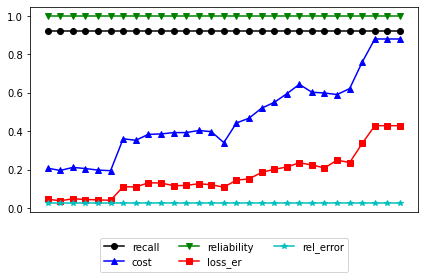

IP-A (recall = 0.9)


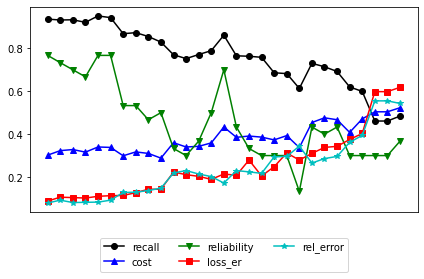

IP-E (recall = 0.9)


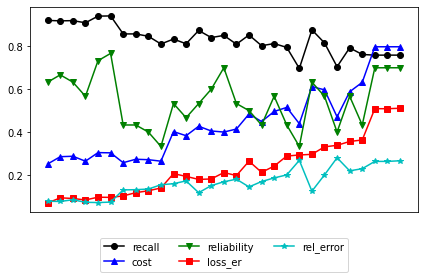

IP-P (recall = 0.9)


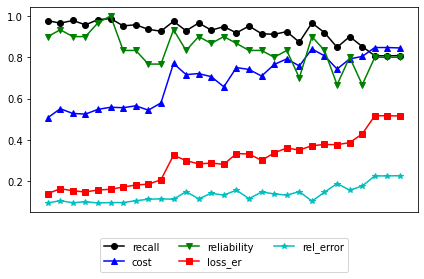

IP-H (recall = 0.9)


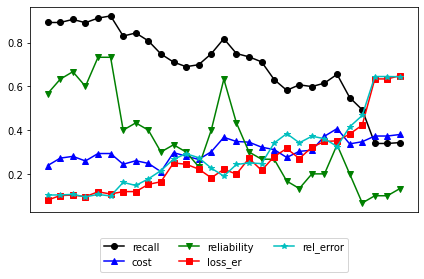

Desired recall: 0.8 Prob: 0.95
run: Waterloo/B-rank-normal.txt
run: AUTH/run-1
run: Waterloo/A-rank-normal.txt
run: AUTH/run-3
run: AUTH/run-4
run: AUTH/run-2
run: Padua/ims_iafa_m10k150f0m10
run: Padua/ims_iafas_m10k50f0m10
run: Padua/ims_iafap_m10p5f0m10
run: Padua/ims_iafap_m10p2f0m10
run: Sheffield/Test_Data_Sheffield-run-4
run: Sheffield/Test_Data_Sheffield-run-2
run: Sheffield/Test_Data_Sheffield-run-3
run: CNRS/trec_no_AF_full_ALL
run: UOS-test/sis.TMAL30Q_BM25.res
run: Sheffield/Test_Data_Sheffield-run-1
run: Baseline/sis.BM25.res
run: CNRS/trec_no_AF_ALL
run: AMC/amc.run.res
run: QUT/coordinateascent_result_pico_ltr_test.txt
run: CNRS/trec_abrupt_ALL
run: QUT/coordinateascent_result_bool_ltr_test.txt
run: QUT/randomforest_result_pico_ltr_test.txt
run: CNRS/trec_gradual_ALL
run: QUT/randomforest_result_bool_ltr_test.txt
run: ECNU/run1.res.txt
run: UCL/run_fulltext_test.txt
run: UCL/run_abstract_test.txt
run: Baseline/pubmed.random.res
run_score_dic: {'OR': {'/content/drive/MyDr

,recall,cost,reliability,loss_er,rel_err,dataset,target_recall,process_type
OR,0.924±0.000,0.471±0.209,1.000±0.000,0.173±0.115,0.027±0.000,CLEF2017,0.9,OR
IP-P,0.923±0.054,0.692±0.117,0.840±0.080,0.299±0.115,0.137±0.040,CLEF2017,0.9,IP
IP-H,0.699±0.171,0.307±0.050,0.354±0.200,0.261±0.161,0.284±0.162,CLEF2017,0.9,IP
IP-E,0.832±0.066,0.444±0.168,0.549±0.123,0.231±0.131,0.164±0.065,CLEF2017,0.9,IP
IP-A,0.759±0.144,0.382±0.069,0.457±0.179,0.252±0.151,0.240±0.140,CLEF2017,0.9,IP
OR,0.830±0.000,0.356±0.205,1.000±0.000,0.140±0.100,0.038±0.000,CLEF2017,0.8,OR
IP-P,0.908±0.067,0.633±0.108,0.872±0.086,0.265±0.108,0.227±0.024,CLEF2017,0.8,IP
IP-H,0.683±0.167,0.286±0.052,0.446±0.258,0.261±0.162,0.298±0.136,CLEF2017,0.8,IP
IP-E,0.785±0.076,0.382±0.157,0.604±0.177,0.223±0.122,0.215±0.055,CLEF2017,0.8,IP
IP-A,0.759±0.144,0.382±0.069,0.601±0.236,0.252±0.151,0.277±0.119,CLEF2017,0.8,IP


OR (recall = 0.8)


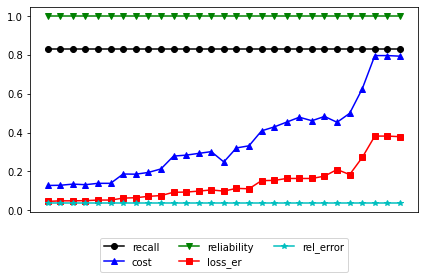

IP-A (recall = 0.8)


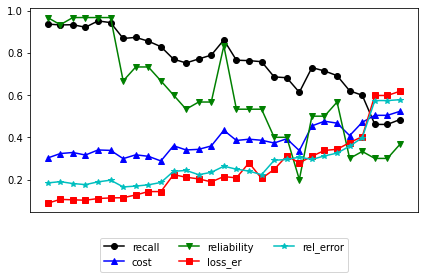

IP-E (recall = 0.8)


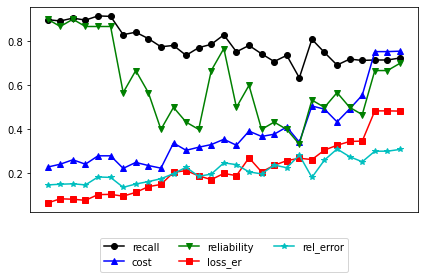

IP-P (recall = 0.8)


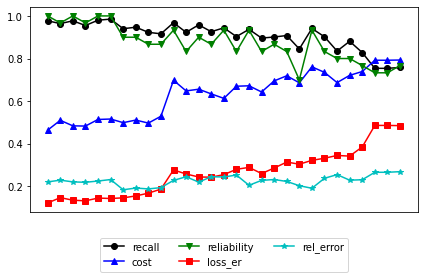

IP-H (recall = 0.8)


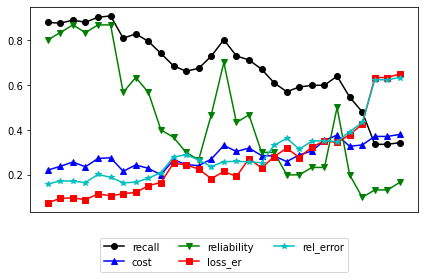

In [ ]:
# Get average results over all runs 

dataset = 'CLEF2017'

# SET EXPERIMENTAL PARAMETERS 
des_recalls = [0.9, 0.8] # desired recalls to experiment over
des_probs = [0.95] # desired confidences to experiment over

for des_prob in des_probs:
    for des_recall in des_recalls: 
        print("Desired recall: {} Prob: {}".format(des_recall, des_prob))
        run_score_dic = get_all_runs_data(des_recall, des_prob, all_runs)
        print("run_score_dic: {}".format(run_score_dic)) 



        df = all_runs_average_scores(run_score_dic)
        df['dataset'] = dataset
        df['target_recall'] = des_recall
        df['process_type'] = 'IP'
        df.loc['OR','process_type'] = 'OR'


        df_all = df_all.append(df) # append all avrg results togather
        display(df_all)
        
        #print(df_all.to_latex(escape=False))
        

        # save all runs scores avrg
        df_all.to_csv(DIR_runs+'results/all_runs_scores.csv')

        # Graph runs 
        graph_all_runs(run_score_dic)



##CX runs

In [ ]:
# Get average results over all runs 

dataset = 'CLEF2017'

# SET EXPERIMENTAL PARAMETERS 
des_recalls = [0.9, 0.8] # desired recalls to experiment over
des_probs = [0.95] # desired confidences to experiment over

for des_prob in des_probs:
    for des_recall in des_recalls: 
        print("Desired recall: {} Prob: {}".format(des_recall, des_prob))
        run_score_dic = get_all_runs_data(des_recall, des_prob, all_runs)
        print("run_score_dic: {}".format(run_score_dic)) 

        df = all_runs_average_scores(run_score_dic)
        df['dataset'] = dataset
        df['target_recall'] = des_recall
        df['process_type'] = 'CX'

        df_all = df_all.append(df) # append all avrg results togather
        display(df_all)
        
        #print(df_all.to_latex(escape=False))
        

        # save all runs scores avrg
        df_all.to_csv(DIR_runs+'results/all_runs_scores_CX.csv')

        # Graph runs 
        graph_all_runs(run_score_dic)



run_score_dic: {'CX-E': {'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2017/runs/Waterloo/B-rank-normal.txt': ('0.924', '0.258', '0.667', '0.071', '0.077'), '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2017/runs/AUTH/run-1': ('0.920', '0.287', '0.700', '0.093', '0.078'), '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2017/runs/Waterloo/A-rank-normal.txt': ('0.923', '0.292', '0.633', '0.090', '0.086'), '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2017/runs/AUTH/run-3': ('0.912', '0.273', '0.567', '0.086', '0.074'), '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2017/runs/AUTH/run-4': ('0.941', '0.309', '0.733', '0.098', '0.071'), '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMulti

,recall,cost,reliability,loss_er,rel_err,dataset,target_recall,process_type
CX-P,0.919±0.058,0.681±0.113,0.820±0.097,0.291±0.111,0.135±0.038,CLEF2017,0.9,CX
CX-H,0.681±0.186,0.304±0.038,0.352±0.215,0.277±0.165,0.305±0.174,CLEF2017,0.9,CX
CX-E,0.839±0.066,0.454±0.168,0.561±0.123,0.232±0.131,0.160±0.065,CLEF2017,0.9,CX
CX-A,0.759±0.144,0.382±0.069,0.457±0.179,0.252±0.151,0.240±0.140,CLEF2017,0.9,CX


CX-E (recall = 0.9)


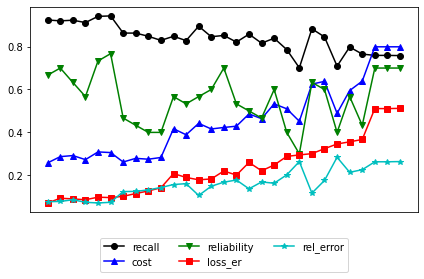

CX-P (recall = 0.9)


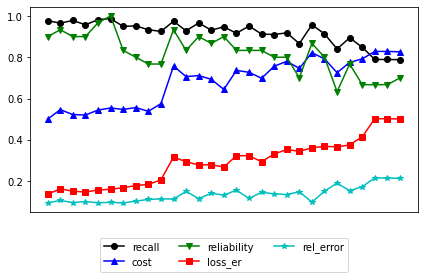

CX-A (recall = 0.9)


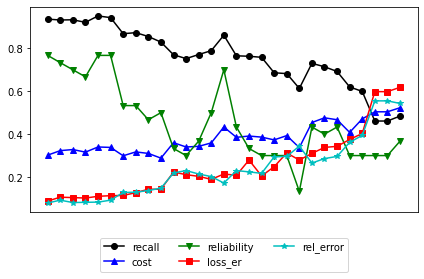

CX-H (recall = 0.9)


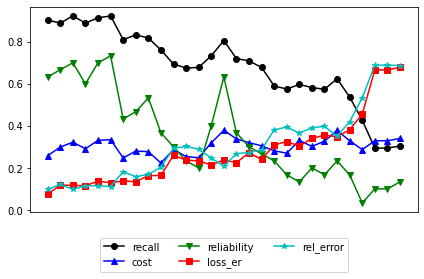

In [ ]:
# Get average results over all runs 

dataset = 'CLEF2017'

# SET EXPERIMENTAL PARAMETERS 
des_recalls = [0.9] # desired recalls to experiment over
des_probs = [0.95] # desired confidences to experiment over

for des_prob in des_probs:
    for des_recall in des_recalls: 
        print("Desired recall: {} Prob: {}".format(des_recall, des_prob))
        run_score_dic = get_all_runs_data(des_recall, des_prob, all_runs)
        print("run_score_dic: {}".format(run_score_dic)) 

        df = all_runs_average_scores(run_score_dic)
        df['dataset'] = dataset
        df['target_recall'] = des_recall
        df['process_type'] = 'CX'
        
        df_all = df_all.append(df) # append all avrg results togather
        display(df_all)

        
        #print(df_all.to_latex(escape=False))
        

        # save all runs scores avrg
        df_all.to_csv(DIR_runs+'results/all_runs_scores_CX.csv')

        # Graph runs 
        graph_all_runs(run_score_dic)



run_score_dic: {'CX-E': {'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2017/runs/Waterloo/B-rank-normal.txt': ('0.901', '0.236', '0.900', '0.071', '0.152'), '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2017/runs/AUTH/run-1': ('0.902', '0.255', '0.867', '0.086', '0.154'), '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2017/runs/Waterloo/A-rank-normal.txt': ('0.910', '0.267', '0.900', '0.083', '0.158'), '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2017/runs/AUTH/run-3': ('0.897', '0.250', '0.867', '0.081', '0.149'), '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2017/runs/AUTH/run-4': ('0.930', '0.292', '0.900', '0.096', '0.171'), '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMulti

,recall,cost,reliability,loss_er,rel_err,dataset,target_recall,process_type
CX-P,0.919±0.058,0.681±0.113,0.820±0.097,0.291±0.111,0.135±0.038,CLEF2017,0.9,CX
CX-H,0.681±0.186,0.304±0.038,0.352±0.215,0.277±0.165,0.305±0.174,CLEF2017,0.9,CX
CX-E,0.839±0.066,0.454±0.168,0.561±0.123,0.232±0.131,0.160±0.065,CLEF2017,0.9,CX
CX-A,0.759±0.144,0.382±0.069,0.457±0.179,0.252±0.151,0.240±0.140,CLEF2017,0.9,CX
CX-P,0.902±0.073,0.621±0.101,0.859±0.102,0.257±0.103,0.223±0.021,CLEF2017,0.8,CX
CX-H,0.679±0.186,0.297±0.037,0.455±0.281,0.275±0.166,0.317±0.146,CLEF2017,0.8,CX
CX-E,0.804±0.071,0.404±0.158,0.648±0.154,0.223±0.125,0.210±0.055,CLEF2017,0.8,CX
CX-A,0.759±0.144,0.382±0.069,0.601±0.236,0.252±0.151,0.277±0.119,CLEF2017,0.8,CX


CX-E (recall = 0.8)


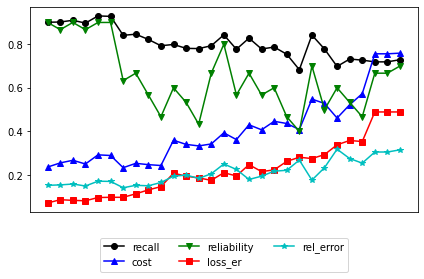

CX-P (recall = 0.8)


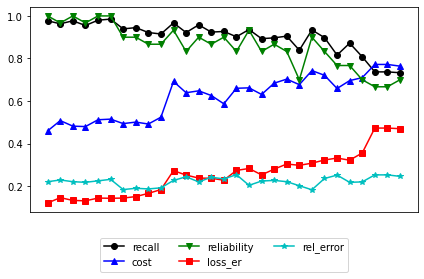

CX-A (recall = 0.8)


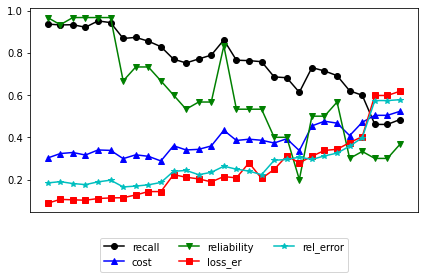

CX-H (recall = 0.8)


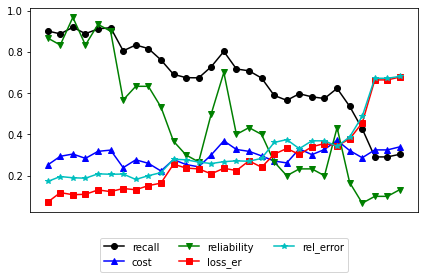

In [ ]:
# Get average results over all runs 

dataset = 'CLEF2017'

# SET EXPERIMENTAL PARAMETERS 
des_recalls = [0.8] # desired recalls to experiment over
des_probs = [0.95] # desired confidences to experiment over

for des_prob in des_probs:
    for des_recall in des_recalls: 
        print("Desired recall: {} Prob: {}".format(des_recall, des_prob))
        run_score_dic = get_all_runs_data(des_recall, des_prob, all_runs)
        print("run_score_dic: {}".format(run_score_dic)) 


        df = all_runs_average_scores(run_score_dic)
        df['dataset'] = dataset
        df['target_recall'] = des_recall
        df['process_type'] = 'CX'
        
        df_all = df_all.append(df) # append all avrg results togather
        display(df_all)

        
        #print(df_all.to_latex(escape=False))
        

        # save all runs scores avrg
        df_all.to_csv(DIR_runs+'results/all_runs_scores_CX.csv')

        # Graph runs 
        graph_all_runs(run_score_dic)



# CLEF 2018 (all runs) 

In [ ]:
# Load data (qrels and list of runs)

qrels = DIR_runs+"CLEFData/clef_runs/2018/relevance/full.test.abs.2018.qrels"
qrel_fname, query_rel_dic = load_rel_data(qrels)
print("Number of topics:", len(query_rel_dic))

# Open list of runs 
RUNDIR = os.path.join(DIR_runs, 'CLEFData/clef_runs/2018/runs/*/*')
all_runs = glob.glob(RUNDIR)  

figs_path = DIR_runs + "figs/"
if not os.path.exists(figs_path):
    os.makedirs(figs_path)
    
# Remove runs that don't include all relevant documents in the ranking 
remove_runs = ['ECNU/ECNU_TASK2_RUN2_LR.task2',
               'ECNU/ECNU_RUN2_LR.task2',
               'ECNU/ECNU_RUN3_COMBINE.task2',
               'CNRS/cnrs_RF_unigram_ALL.task2',
               'CNRS/cnrs_combined_ALL.task2',
               'CNRS/cnrs_RF_bigram_ALL.task2',
               'AUTh/auth_run1_All.task2',
               'AUTh/auth_run2_1000.task2',
               'AUTh/auth_run3_1000.task2',
               'UWaterloo/UWA.task2',
               'UWaterloo/UWB.task2']            
               
for run in remove_runs: 
    run_path = os.path.join(DIR_runs, 'CLEFData/clef_runs/2018/runs/', run)
    all_runs.remove(run_path)

# print(f"allRuns {all_runs}")
print(f"Number of runs: {len(all_runs)}")

Number of topics: 30
Number of runs: 11


In [ ]:
# Read in list of run scores from file and store in dict
# (Need to change path format to allow matching)
run_scores = 'CLEFData/run_rankings/runs2018_AURC.csv'
run_scores_path = os.path.join(DIR_runs, run_scores)
run_score_dic = {}
with open(run_scores_path, mode='r') as infile:
    reader = csv.reader(infile)
    # N.B. Change path so dictionaries match
    run_score_dic = {os.path.join(DIR_runs, 'CLEFData/clef_runs/2018/runs/', rows[0]):rows[1] for rows in reader}
print(run_score_dic)

# Sort runs by AURC scores based on dict (highest to lowest)
all_runs = sorted(all_runs, key=lambda x: run_score_dic[x], reverse=True)
aurc_scores = []
for r in all_runs: 
    aurc_scores.append(run_score_dic[r])
print("aurc_scores: {}".format(aurc_scores))
# print("newlist: {}".format(newlist)) 

#print("all_runs: {}".format(all_runs))
#print("run_score_dict: {}".format(run_score_dic))

# print(f"allRuns {all_runs}")
# print(f"Number of runs: {len(all_runs)}")

{'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/UIC/uci_model8.task2': ' 0.733', '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/UIC/uic_model7.task2': ' 0.744', '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/IMS/ims_unipd_t1500.task2': ' 0.896', '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/IMS/ims_unipd_t1000.task2': ' 0.9', '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/IMS/ims_unipd_t500.task2': ' 0.911', '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/ECNU/ECNU_TASK2_RUN3_COMBINE.task2': ' 0.687', '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFDa

## IP runs

Desired recall: 0.9 Prob: 0.95
run: SHEF/sheffield-feedback.task2
run: IMS/ims_unipd_t500.task2
run: IMS/ims_unipd_t1000.task2
run: IMS/ims_unipd_t1500.task2
run: SHEF/sheffield-general_terms.task2
run: SHEF/sheffield-query_terms.task2
run: UIC/uic_model7.task2
run: UIC/uci_model8.task2
run: ECNU/ECNU_TASK2_RUN3_COMBINE.task2
run: ECNU/ECNU_TASK2_RUN1_TFIDF.task2
run: ECNU/ECNU_RUN1_TFIDF.task2
run_score_dic: {'OR': {'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/SHEF/sheffield-feedback.task2': ('0.912', '0.259', '1.000', '0.040', '0.013'), '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/IMS/ims_unipd_t500.task2': ('0.912', '0.272', '1.000', '0.062', '0.013'), '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/IMS/ims_unipd_t1000.task2': ('0.912', '0.316', '1.000', '0.072', '0.013'), '/content

,recall,cost,reliability,loss_er,rel_err,dataset,target_recall,process_type
OR,0.924±0.000,0.471±0.209,1.000±0.000,0.173±0.115,0.027±0.000,CLEF2017,0.9,OR
IP-P,0.923±0.054,0.692±0.117,0.840±0.080,0.299±0.115,0.137±0.040,CLEF2017,0.9,IP
IP-H,0.699±0.171,0.307±0.050,0.354±0.200,0.261±0.161,0.284±0.162,CLEF2017,0.9,IP
IP-E,0.832±0.066,0.444±0.168,0.549±0.123,0.231±0.131,0.164±0.065,CLEF2017,0.9,IP
IP-A,0.759±0.144,0.382±0.069,0.457±0.179,0.252±0.151,0.240±0.140,CLEF2017,0.9,IP
OR,0.830±0.000,0.356±0.205,1.000±0.000,0.140±0.100,0.038±0.000,CLEF2017,0.8,OR
IP-P,0.908±0.067,0.633±0.108,0.872±0.086,0.265±0.108,0.227±0.024,CLEF2017,0.8,IP
IP-H,0.683±0.167,0.286±0.052,0.446±0.258,0.261±0.162,0.298±0.136,CLEF2017,0.8,IP
IP-E,0.785±0.076,0.382±0.157,0.604±0.177,0.223±0.122,0.215±0.055,CLEF2017,0.8,IP
IP-A,0.759±0.144,0.382±0.069,0.601±0.236,0.252±0.151,0.277±0.119,CLEF2017,0.8,IP


OR (recall = 0.9)


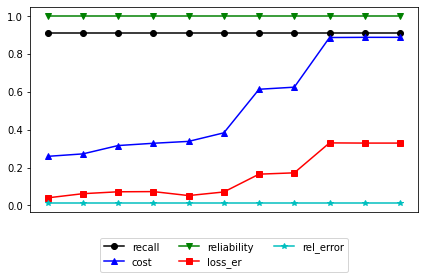

IP-A (recall = 0.9)


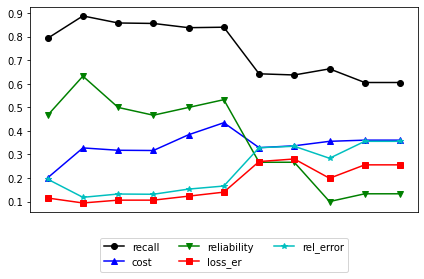

IP-E (recall = 0.9)


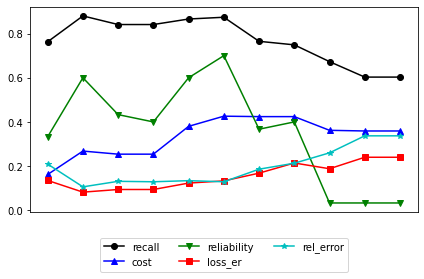

IP-P (recall = 0.9)


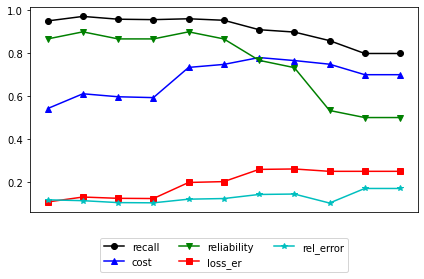

IP-H (recall = 0.9)


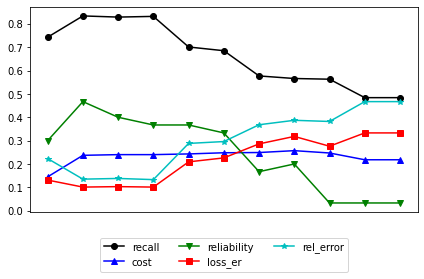

Desired recall: 0.8 Prob: 0.95
run: SHEF/sheffield-feedback.task2
run: IMS/ims_unipd_t500.task2
run: IMS/ims_unipd_t1000.task2
run: IMS/ims_unipd_t1500.task2
run: SHEF/sheffield-general_terms.task2
run: SHEF/sheffield-query_terms.task2
run: UIC/uic_model7.task2
run: UIC/uci_model8.task2
run: ECNU/ECNU_TASK2_RUN3_COMBINE.task2
run: ECNU/ECNU_TASK2_RUN1_TFIDF.task2
run: ECNU/ECNU_RUN1_TFIDF.task2
run_score_dic: {'OR': {'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/SHEF/sheffield-feedback.task2': ('0.811', '0.166', '1.000', '0.050', '0.014'), '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/IMS/ims_unipd_t500.task2': ('0.811', '0.175', '1.000', '0.065', '0.014'), '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/IMS/ims_unipd_t1000.task2': ('0.811', '0.193', '1.000', '0.066', '0.014'), '/content

,recall,cost,reliability,loss_er,rel_err,dataset,target_recall,process_type
OR,0.924±0.000,0.471±0.209,1.000±0.000,0.173±0.115,0.027±0.000,CLEF2017,0.9,OR
IP-P,0.923±0.054,0.692±0.117,0.840±0.080,0.299±0.115,0.137±0.040,CLEF2017,0.9,IP
IP-H,0.699±0.171,0.307±0.050,0.354±0.200,0.261±0.161,0.284±0.162,CLEF2017,0.9,IP
IP-E,0.832±0.066,0.444±0.168,0.549±0.123,0.231±0.131,0.164±0.065,CLEF2017,0.9,IP
IP-A,0.759±0.144,0.382±0.069,0.457±0.179,0.252±0.151,0.240±0.140,CLEF2017,0.9,IP
OR,0.830±0.000,0.356±0.205,1.000±0.000,0.140±0.100,0.038±0.000,CLEF2017,0.8,OR
IP-P,0.908±0.067,0.633±0.108,0.872±0.086,0.265±0.108,0.227±0.024,CLEF2017,0.8,IP
IP-H,0.683±0.167,0.286±0.052,0.446±0.258,0.261±0.162,0.298±0.136,CLEF2017,0.8,IP
IP-E,0.785±0.076,0.382±0.157,0.604±0.177,0.223±0.122,0.215±0.055,CLEF2017,0.8,IP
IP-A,0.759±0.144,0.382±0.069,0.601±0.236,0.252±0.151,0.277±0.119,CLEF2017,0.8,IP


OR (recall = 0.8)


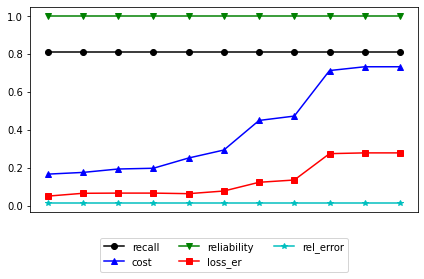

IP-A (recall = 0.8)


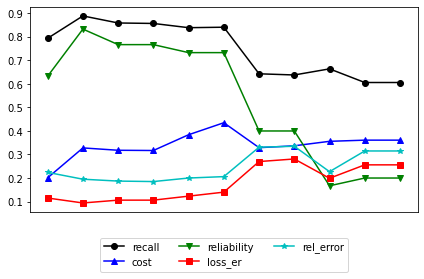

IP-E (recall = 0.8)


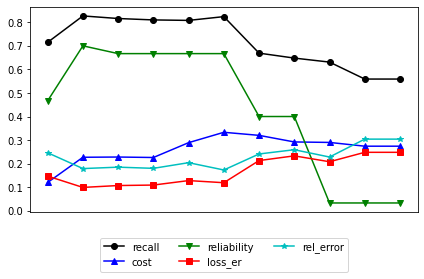

IP-P (recall = 0.8)


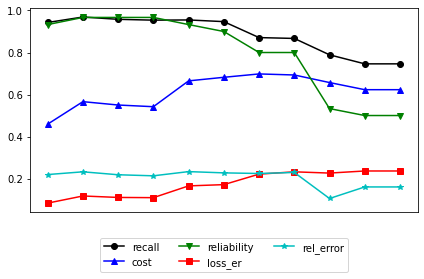

IP-H (recall = 0.8)


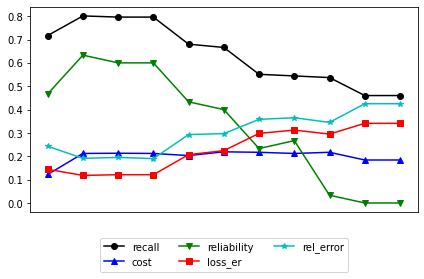

In [ ]:
# Get average results over all runs 

dataset = 'CLEF2018'


# SET EXPERIMENTAL PARAMETERS 
des_recalls = [0.9, 0.8] # desired recalls to experiment over
des_probs = [0.95] # desired confidences to experiment over

for des_prob in des_probs:
    for des_recall in des_recalls: 
        print("Desired recall: {} Prob: {}".format(des_recall, des_prob))
        run_score_dic = get_all_runs_data(des_recall, des_prob, all_runs)
        print("run_score_dic: {}".format(run_score_dic))   

        # save all runs        
        df_run = pd.concat({k: pd.DataFrame(v).T for k, v in run_score_dic.items()}, axis=0)
        df_run.rename(columns = {0:'recall', 1:'cost', 2:'reliability', 3:'loss_er', 4:'rel_err'}, inplace = True)
        df_run['dataset'] = dataset
        df_run['target_recall'] = des_recall
        df_run['process_type'] = 'IP'
        df_run.loc['OR','process_type'] = 'OR'

        df_run.to_csv(DIR_runs+'each_run.csv')
        df_runs = df_runs.append(df_run) # append all runs togather

        df = all_runs_average_scores(run_score_dic)
        df['dataset'] = dataset
        df['target_recall'] = des_recall
        df['process_type'] = 'IP'

        df_all = df_all.append(df) # append all avrg results togather
        display(df_all)

        
        #print(df_all.to_latex(escape=False))
        

        # save all runs scores avrg
        df_all.to_csv(DIR_runs+'results/all_runs_scores.csv')

        # Graph runs 
        graph_all_runs(run_score_dic)


In [ ]:
df_all.sort_values(by=['target_recall','dataset'], ascending=[False,True])

,recall,cost,reliability,loss_er,rel_err,dataset,target_recall,process_type
OR,0.924±0.000,0.471±0.209,1.000±0.000,0.173±0.115,0.027±0.000,CLEF2017,0.9,OR
IP-P,0.923±0.054,0.692±0.117,0.840±0.080,0.299±0.115,0.137±0.040,CLEF2017,0.9,IP
IP-H,0.699±0.171,0.307±0.050,0.354±0.200,0.261±0.161,0.284±0.162,CLEF2017,0.9,IP
IP-E,0.832±0.066,0.444±0.168,0.549±0.123,0.231±0.131,0.164±0.065,CLEF2017,0.9,IP
IP-A,0.759±0.144,0.382±0.069,0.457±0.179,0.252±0.151,0.240±0.140,CLEF2017,0.9,IP
OR,0.912±0.000,0.527±0.261,1.000±0.000,0.154±0.120,0.013±0.000,CLEF2018,0.9,IP
IP-P,0.911±0.065,0.684±0.083,0.755±0.165,0.195±0.063,0.127±0.025,CLEF2018,0.9,IP
IP-H,0.663±0.136,0.231±0.031,0.245±0.160,0.220±0.096,0.299±0.127,CLEF2018,0.9,IP
IP-E,0.769±0.104,0.334±0.087,0.357±0.237,0.156±0.058,0.197±0.083,CLEF2018,0.9,IP
IP-A,0.749±0.116,0.339±0.057,0.364±0.188,0.177±0.076,0.232±0.099,CLEF2018,0.9,IP


##CX runs

Desired recall: 0.9 Prob: 0.95
run: SHEF/sheffield-feedback.task2
run_score_dic: {'CX-E': {'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/SHEF/sheffield-feedback.task2': ('0.756', '0.160', '0.333', '0.139', '0.216')}, 'CX-P': {'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/SHEF/sheffield-feedback.task2': ('0.949', '0.527', '0.867', '0.101', '0.113')}, 'CX-A': {'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/SHEF/sheffield-feedback.task2': ('0.794', '0.201', '0.467', '0.115', '0.195')}, 'CX-H': {'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/SHEF/sheffield-feedback.task2': ('0.748', '0.172', '0.367', '0.142', '0.233')}}
run: IMS/ims_unipd_t500.task2
run_score_dic: {'CX-E': {'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TO

,recall,cost,reliability,loss_er,rel_err,dataset,target_recall,process_type
CX-P,0.919±0.058,0.681±0.113,0.820±0.097,0.291±0.111,0.135±0.038,CLEF2017,0.9,CX
CX-H,0.681±0.186,0.304±0.038,0.352±0.215,0.277±0.165,0.305±0.174,CLEF2017,0.9,CX
CX-E,0.839±0.066,0.454±0.168,0.561±0.123,0.232±0.131,0.160±0.065,CLEF2017,0.9,CX
CX-A,0.759±0.144,0.382±0.069,0.457±0.179,0.252±0.151,0.240±0.140,CLEF2017,0.9,CX
CX-P,0.902±0.073,0.621±0.101,0.859±0.102,0.257±0.103,0.223±0.021,CLEF2017,0.8,CX
CX-H,0.679±0.186,0.297±0.037,0.455±0.281,0.275±0.166,0.317±0.146,CLEF2017,0.8,CX
CX-E,0.804±0.071,0.404±0.158,0.648±0.154,0.223±0.125,0.210±0.055,CLEF2017,0.8,CX
CX-A,0.759±0.144,0.382±0.069,0.601±0.236,0.252±0.151,0.277±0.119,CLEF2017,0.8,CX
CX-P,0.905±0.069,0.672±0.080,0.712±0.227,0.191±0.062,0.126±0.025,CLEF2018,0.9,CX
CX-H,0.649±0.139,0.233±0.025,0.257±0.171,0.239±0.098,0.319±0.128,CLEF2018,0.9,CX


CX-E (recall = 0.9)


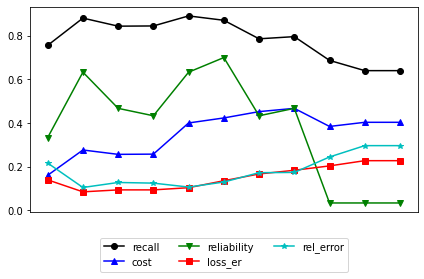

CX-P (recall = 0.9)


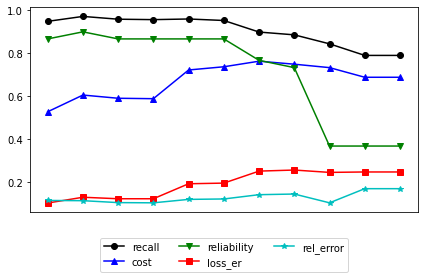

CX-A (recall = 0.9)


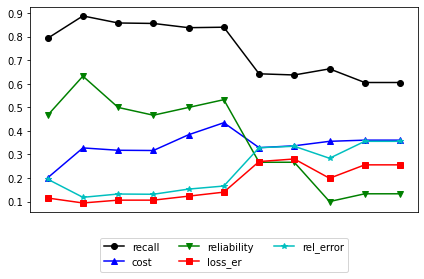

CX-H (recall = 0.9)


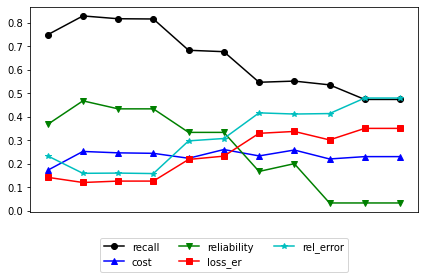

In [ ]:
# Get average results over all runs 

dataset = 'CLEF2018'


# SET EXPERIMENTAL PARAMETERS 
des_recalls = [0.9] # desired recalls to experiment over
des_probs = [0.95] # desired confidences to experiment over

for des_prob in des_probs:
    for des_recall in des_recalls: 
        print("Desired recall: {} Prob: {}".format(des_recall, des_prob))
        run_score_dic = get_all_runs_data(des_recall, des_prob, all_runs)
        print("run_score_dic: {}".format(run_score_dic))   

        df = all_runs_average_scores(run_score_dic)
        df['dataset'] = dataset
        df['target_recall'] = des_recall
        df['process_type'] = 'CX'
        
        df_all = df_all.append(df) # append all results togather
        display(df_all)
        
        #print(df_all.to_latex(escape=False))
        

        # save all runs scores avrg
        df_all.to_csv(DIR_runs+'results/all_runs_scores_CX.csv')

        # Graph runs 
        graph_all_runs(run_score_dic)



Desired recall: 0.8 Prob: 0.95
run: SHEF/sheffield-feedback.task2
run_score_dic: {'CX-E': {'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/SHEF/sheffield-feedback.task2': ('0.732', '0.137', '0.500', '0.147', '0.241')}, 'CX-P': {'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/SHEF/sheffield-feedback.task2': ('0.941', '0.450', '0.933', '0.081', '0.217')}, 'CX-A': {'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/SHEF/sheffield-feedback.task2': ('0.794', '0.201', '0.633', '0.115', '0.224')}, 'CX-H': {'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/RunMultipleRankings/CLEFData/clef_runs/2018/runs/SHEF/sheffield-feedback.task2': ('0.744', '0.158', '0.533', '0.140', '0.253')}}
run: IMS/ims_unipd_t500.task2
run_score_dic: {'CX-E': {'/content/drive/MyDrive/ReemSharedPhD/SharedCode/TO

,recall,cost,reliability,loss_er,rel_err,dataset,target_recall,process_type
CX-P,0.919±0.058,0.681±0.113,0.820±0.097,0.291±0.111,0.135±0.038,CLEF2017,0.9,CX
CX-H,0.681±0.186,0.304±0.038,0.352±0.215,0.277±0.165,0.305±0.174,CLEF2017,0.9,CX
CX-E,0.839±0.066,0.454±0.168,0.561±0.123,0.232±0.131,0.160±0.065,CLEF2017,0.9,CX
CX-A,0.759±0.144,0.382±0.069,0.457±0.179,0.252±0.151,0.240±0.140,CLEF2017,0.9,CX
CX-P,0.905±0.069,0.672±0.080,0.712±0.227,0.191±0.062,0.126±0.025,CLEF2018,0.9,CX
CX-H,0.649±0.139,0.233±0.025,0.257±0.171,0.239±0.098,0.319±0.128,CLEF2018,0.9,CX
CX-E,0.785±0.094,0.353±0.099,0.382±0.248,0.150±0.054,0.181±0.072,CLEF2018,0.9,CX
CX-A,0.749±0.116,0.339±0.057,0.364±0.188,0.177±0.076,0.232±0.099,CLEF2018,0.9,CX
CX-P,0.902±0.073,0.621±0.101,0.859±0.102,0.257±0.103,0.223±0.021,CLEF2017,0.8,CX
CX-H,0.679±0.186,0.297±0.037,0.455±0.281,0.275±0.166,0.317±0.146,CLEF2017,0.8,CX


CX-E (recall = 0.8)


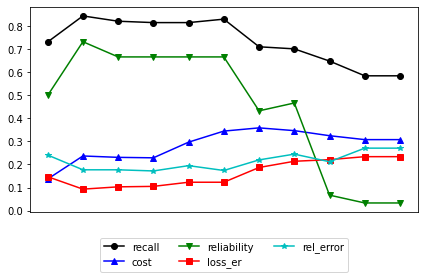

CX-P (recall = 0.8)


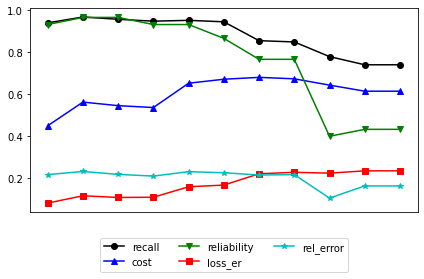

CX-A (recall = 0.8)


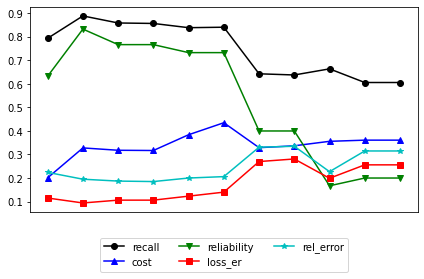

CX-H (recall = 0.8)


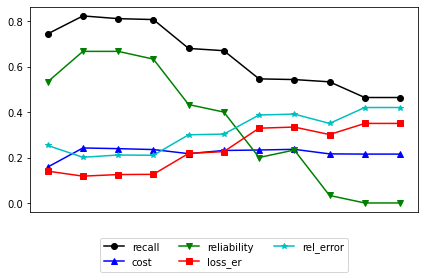

In [ ]:
# Get average results over all runs 

dataset = 'CLEF2018'


# SET EXPERIMENTAL PARAMETERS 
des_recalls = [ 0.8] # desired recalls to experiment over
des_probs = [0.95] # desired confidences to experiment over

for des_prob in des_probs:
    for des_recall in des_recalls: 
        print("Desired recall: {} Prob: {}".format(des_recall, des_prob))
        run_score_dic = get_all_runs_data(des_recall, des_prob, all_runs)
        print("run_score_dic: {}".format(run_score_dic))   

        df = all_runs_average_scores(run_score_dic)
        df['dataset'] = dataset
        df['target_recall'] = des_recall
        df['process_type'] = 'CX'
        
        df_all = df_all.append(df) # append all results togather
        display(df_all)
        
        #print(df_all.to_latex(escape=False))
        

        # save all runs scores avrg
        df_all.to_csv(DIR_runs+'results/all_runs_scores_CX.csv')

        # Graph runs 
        graph_all_runs(run_score_dic)



# Combine OR, IP & CX results

In [ ]:
# merge IP & CX dataframes
df_all_IP = pd.read_csv(DIR_runs+'results/all_runs_scores.csv', index_col=0)
df_all_CX = pd.read_csv(DIR_runs+'results/all_runs_scores_CX.csv', index_col=0)

df_all = pd.concat([df_all_IP,df_all_CX])
df_all = df_all.sort_values(by=['target_recall','dataset'], ascending=[False,True])

df_all.to_csv(DIR_runs+'results/all_runs_scores_OR_IP_CX.csv')

df_all


,recall,cost,reliability,loss_er,rel_err,dataset,target_recall,process_type
OR,0.924±0.000,0.471±0.209,1.000±0.000,0.173±0.115,0.027±0.000,CLEF2017,0.9,OR
IP-P,0.923±0.054,0.692±0.117,0.840±0.080,0.299±0.115,0.137±0.040,CLEF2017,0.9,IP
IP-H,0.699±0.171,0.307±0.050,0.354±0.200,0.261±0.161,0.284±0.162,CLEF2017,0.9,IP
IP-E,0.832±0.066,0.444±0.168,0.549±0.123,0.231±0.131,0.164±0.065,CLEF2017,0.9,IP
IP-A,0.759±0.144,0.382±0.069,0.457±0.179,0.252±0.151,0.240±0.140,CLEF2017,0.9,IP
CX-P,0.919±0.058,0.681±0.113,0.820±0.097,0.291±0.111,0.135±0.038,CLEF2017,0.9,CX
CX-H,0.681±0.186,0.304±0.038,0.352±0.215,0.277±0.165,0.305±0.174,CLEF2017,0.9,CX
CX-E,0.839±0.066,0.454±0.168,0.561±0.123,0.232±0.131,0.160±0.065,CLEF2017,0.9,CX
CX-A,0.759±0.144,0.382±0.069,0.457±0.179,0.252±0.151,0.240±0.140,CLEF2017,0.9,CX
OR,0.912±0.000,0.527±0.261,1.000±0.000,0.154±0.120,0.013±0.000,CLEF2018,0.9,OR
